# ===============第一阶段：数据源获取数据===============

# 引入依赖

In [1]:
import collections
import numpy as np
import os
import pandas as pd
import pymysql
import time

# 定义需要的工具类，如数据库读取类，数据拼装类

In [2]:
class MySQLReader:
    """Reader for mysql."""

    def __init__(self, host, port, user, password, database):
        """Initialize the mysql."""
        self.mysql = pymysql.connect(host=host,
                                     port=port,
                                     user=user,
                                     password=password,
                                     database=database,
                                     charset="utf8")
        self.cursor = self.mysql.cursor()

    def fetch_result(self, sql, fetch_one=False):
        """Fetch mysql results by received sql."""
        if not sql:
            raise ValueError("No sql command detected.")

        self.cursor.execute(sql)
        if fetch_one:
            return self.cursor.fetchone()
        return self.cursor.fetchall()

    def mysql_close(self):
        """Close the connection of db."""
        self.cursor.close()
        self.mysql.close()

class DataFormat:
    """Used for data format."""

    def __init__(self, cursor=None, db_result=None):
        """Initialize the db_result."""
        self.cursor = cursor
        self.db_result = db_result

    def set_db_result(self, db_result):
        """Update the db_result."""
        self.db_result = db_result

    def result_to_df(self, cursor=None, db_result=None):
        """Convert to df."""
        db_result = db_result if db_result else self.db_result
        cursor = cursor if cursor else self.cursor
        columns = [col[0] for col in cursor.description]
        columns = [column.split(".")[-1] for column in columns]
        result = [collections.OrderedDict(zip(columns, list(row))) for row in db_result]
        return pd.DataFrame(result)

    def get_target_columns(self, target_columns_str=None, target_columns_list=None, cursor=None, db_result=None):
        """Get the target columns."""
        db_result = db_result if db_result is not None else self.db_result
        cursor = cursor if cursor else self.cursor
        if not target_columns_list and not target_columns_str:
            return self.result_to_df(cursor=cursor, db_result=db_result) if isinstance(db_result, tuple) else db_result

        if not target_columns_list:
            target_columns_list = target_columns_str.split(",")
        target_columns_list = [each.strip() for each in target_columns_list]
        if isinstance(db_result, pd.DataFrame):
            return db_result[target_columns_list]
        if isinstance(db_result, tuple):
            origin_df = self.result_to_df(cursor, db_result)
            return origin_df[target_columns_list]
        return db_result

# 给定数据库相关信息

In [3]:
mysql_host, mysql_port = "127.0.0.1", 3306
user, password = "root", "root"
database = "test"
mysql_ins = MySQLReader(mysql_host, mysql_port, user, password, database)

# 给定语句，查询结果

In [4]:
sql_command = "select * from sample_data;"
table_infos = mysql_ins.fetch_result(sql_command)

data_ins = DataFormat(mysql_ins.cursor, table_infos)
format_data_df = data_ins.result_to_df()

In [5]:
format_data_df

,int_column_one,id,str_column_one,double_column_one,int_column_two,data_type
0,1,1,str_one,10.0,2,0
1,2,2,str_two,20.0,4,0
2,3,3,str_three,30.0,6,1
3,4,4,str_four,40.0,8,1


# Optional: 选择目标列，进行简单过滤

In [6]:
# 以下两种方式都可以，如果前面在sql中已经过滤完了，那么这里可以跳过
target_columns_str = "int_column_one,double_column_one, int_column_two,data_type"  # 字符串形式，中间有无空格都行，逗号隔开即可。
format_data_df = data_ins.get_target_columns(target_columns_str=target_columns_str, db_result=format_data_df)
print(format_data_df, end="\n")
print("=" * 100)
target_columns_list = ["int_column_one", "double_column_one", "int_column_two", "data_type"]  # 列表形式
format_data_df = data_ins.get_target_columns(target_columns_list=target_columns_list, db_result=format_data_df)
print(format_data_df)

   int_column_one  double_column_one  int_column_two  data_type
0               1               10.0               2          0
1               2               20.0               4          0
2               3               30.0               6          1
3               4               40.0               8          1
   int_column_one  double_column_one  int_column_two  data_type
0               1               10.0               2          0
1               2               20.0               4          0
2               3               30.0               6          1
3               4               40.0               8          1


# 关闭数据库连接

In [7]:
mysql_ins.mysql_close()

# ===============第二阶段：数据简单加工处理===============

In [8]:
# 视情况增加新列
# 自身平方
format_data_df["new_one"] = format_data_df["int_column_one"].map(lambda x: x**2)
# 两列相交互
format_data_df["new_two"] = format_data_df.apply(lambda x: x['int_column_one'] + 0.1 * x['double_column_one'], axis=1)
# 对数据进行分组后再做计算，比如按data_type进行分组，然后随意：（本组均值-当前值）/本组总数量
format_data_df["new_three"] = format_data_df.groupby('data_type')['int_column_one'].transform(
    lambda x: (x.mean() - x) / x.count())
format_data_df

,int_column_one,double_column_one,int_column_two,data_type,new_one,new_two,new_three
0,1,10.0,2,0,1,2.0,0.25
1,2,20.0,4,0,4,4.0,-0.25
2,3,30.0,6,1,9,6.0,0.25
3,4,40.0,8,1,16,8.0,-0.25


# Optional:数据结果保存至本地文件

In [9]:
# 这里文件名以时间戳.csv的格式来保存，可以自行修改。
file_name = time.strftime("%Y_%m%d_%H%M", time.localtime(time.time())) + ".csv"
data_path = os.path.join(os.getcwd(), file_name)  # 保存在当前脚本的同目录下
format_data_df.to_csv(data_path, index=None, encoding='utf-8')

# Optional: 对应的读数据

In [10]:
format_data_df = pd.read_csv(file_name)
format_data_df

,int_column_one,double_column_one,int_column_two,data_type,new_one,new_two,new_three
0,1,10.0,2,0,1,2.0,0.25
1,2,20.0,4,0,4,4.0,-0.25
2,3,30.0,6,1,9,6.0,0.25
3,4,40.0,8,1,16,8.0,-0.25


# ===============第三阶段：可视化展示===============

In [11]:
# 以浮框形式展示，默认是在控制台输出
# %matplotlib tk

# 画图相关的包

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

# 一些通用的设置

In [13]:
# 目的为了能展示中文字符
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

# 柱状图(一)：同一行数据落到相同柱子上

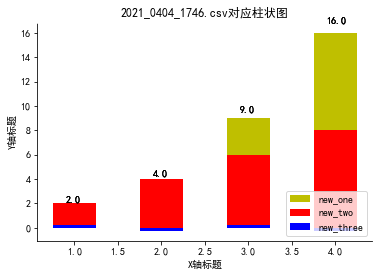

In [14]:
def autolabel(*rects):
    temp = [[each.get_height() for each in rect] for rect in rects]
    temp = np.array(temp).T   # 转置是为了横向比较每根柱子谁最高
    heights = [max(each) for each in temp]  # 找出最高，只标记最高
    for rect in rects:
        for idx in range(len(rects[0])):
            height = heights[idx]
            plt.text(rect[idx].get_x()+rect[idx].get_width()/2.-0.1, 1.05*height, f'{height}')

bar_width = 0.5
rows, columns = format_data_df.shape
x_points = np.array([each+1 for each in np.arange(rows).tolist()])
bar_1 = plt.bar(x_points, format_data_df["new_one"], color="y", label="new_one", width=bar_width)
bar_2 = plt.bar(x_points, format_data_df["new_two"], color="r", label="new_two",width=bar_width)
bar_3 = plt.bar(x_points, format_data_df["new_three"], color="blue", label="new_three", width=bar_width)
# 显示高度
autolabel(bar_1, bar_2, bar_3)
# 加上标注，明确指定放在右下角，默认左上角
plt.legend(loc="lower right")  
# 边框美化，去掉右侧和上侧
ax = plt.gca() 
ax.spines["right"].set_color("w")
ax.spines["top"].set_color("w") 
# 添加坐标轴名称
plt.title(f"{file_name}对应柱状图")
plt.xlabel("X轴标题")
plt.ylabel("Y轴标题")
# plt.savefig(file_name.split(".")[0] + "柱状图.jpg")  # 这个是为了能保存下来图片
plt.show()

# 柱状图(二)：同一行数据呈并列柱子

[[1, 4, 9, 16], [2.0, 4.0, 6.0, 8.0], [0.25, -0.25, 0.25, -0.25]]


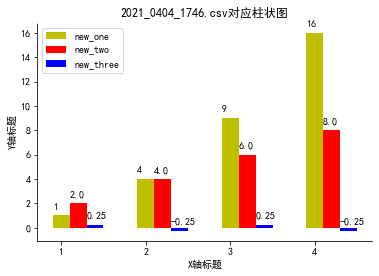

In [15]:
def autolabel(*rects):
    heights = [[each.get_height() for each in rect] for rect in rects]
    print(heights)
    for idx_x in range(len(rects)):
        rect = rects[idx_x]
        for idx_y in range(len(rect)):
            height = heights[idx_x][idx_y]
            plt.text(rect[idx_y].get_x()+rect[idx_y].get_width()/2.-0.1, 0.5 + height, f'{height}')

bar_width = 0.2
rows, columns = format_data_df.shape
x_points = np.array([each+1 for each in np.arange(rows).tolist()])
bar_1 = plt.bar(x_points, format_data_df["new_one"], color="y", label="new_one", width=bar_width)
bar_2 = plt.bar(x_points+bar_width, format_data_df["new_two"], color="r", label="new_two",width=bar_width)
bar_3 = plt.bar(x_points+2*bar_width, format_data_df["new_three"], color="blue", label="new_three", width=bar_width)
#设定X轴和Y轴的刻度间隔
ax = plt.gca()  # ax为两条坐标轴的实例
x_major_locator = MultipleLocator(1)
y_major_locator = MultipleLocator(2)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
# 显示高度
autolabel(bar_1, bar_2, bar_3)
# 显示标签
plt.legend()
# 边框美化，去掉右侧和上侧
ax = plt.gca() 
ax.spines["right"].set_color("w")
ax.spines["top"].set_color("w") 
# 添加坐标轴名称
plt.title(f"{file_name}对应柱状图")
plt.xlabel("X轴标题")
plt.ylabel("Y轴标题")
plt.show()

# 折线图

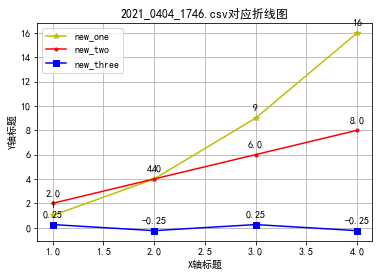

In [16]:
def autolabel(x, *ys):
    for y in ys:
        for x_point, y_point in zip(x, y):
            plt.text(x_point, y_point + 0.5, str(y_point), ha='center', va='bottom', fontsize=10, rotation=0)

ax = plt.gca()  # ax为两条坐标轴的实例
x_points = np.array([each+1 for each in np.arange(rows).tolist()])

ax.plot(x_points, format_data_df["new_one"], "*-", color="y", label="new_one")
ax.plot(x_points, format_data_df["new_two"], ".-", color="r", label="new_two")
ax.plot(x_points, format_data_df["new_three"], "s-", color="b", label="new_three")

# 设定坐标轴标题以及图标题
ax.set(xlabel="X轴标题", ylabel="Y轴标题", title=f"{file_name}对应折线图")
# 添加网格
ax.grid()
# 显示高度
autolabel(x_points, format_data_df["new_one"], format_data_df["new_two"], format_data_df["new_three"])  # 在各点上标记上出Y值
# 显示标签
plt.legend()
# plt.savefig(file_name.split(".")[0] + "折线图.jpg")  # 这个是为了能保存下来图片
plt.show()